In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 60)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 80)
pd.set_option('display.max_colwidth', 50)

In [2]:
# Replace the paths with the actual paths to your JSON files
kiosk_data_json_path = '../../data/raw/metro_bike_kiosks.json'
trip_data_csv_path = '../../data/raw/Austin_MetroBike_Trips_20231231.csv'
trip_data_json_path = '../../data/raw/Austin_MetroBike_Trips.json'

try:
    # Loading the kiosk data into a DataFrame
    kiosk_df = pd.read_json(kiosk_data_json_path)

    dtype_dict = {
        'Trip ID': 'int64',
        'Membership or Pass Type': 'str',
        'Bicycle ID': 'str',
        'Bike Type': 'str',
        'Checkout Datetime': 'str',  # or 'datetime64' if you want to parse dates
        'Checkout Date': 'str',  # or 'datetime64'
        'Checkout Time': 'str',
        'Checkout Kiosk ID': 'str',
        'Checkout Kiosk': 'str',
        'Return Kiosk ID': 'str',
        'Return Kiosk': 'str',
        'Trip Duration Minutes': 'int64',
        'Month': 'str',
        'Year': 'int64'
    }

    trip_df = pd.read_json(trip_data_json_path, lines=True)

    # Normalizing the 'location' column and splitting it into 'latitude' and 'longitude'
    location_df = pd.json_normalize(kiosk_df['location'])
    kiosk_df = pd.concat([kiosk_df.drop(columns=['location']), location_df], axis=1)

    dtype_dict = {
        'Trip ID': 'int64',
        'Membership or Pass Type': 'str',
        'Bicycle ID': 'str',
        'Bike Type': 'str',
        'Checkout Datetime': 'str',  # or 'datetime64' if you want to parse dates
        'Checkout Date': 'str',  # or 'datetime64'
        'Checkout Time': 'str',
        'Checkout Kiosk ID': 'str',
        'Checkout Kiosk': 'str',
        'Return Kiosk ID': 'str',
        'Return Kiosk': 'str',
        'Trip Duration Minutes': 'int64',
        'Month': 'str',
        'Year': 'int64'
    }

    # # Load the CSV file into a DataFrame
    # trip_df = pd.read_csv(trip_data_csv_path, dtype=dtype_dict)

    # # Save the DataFrame as a JSON file
    # trip_df.to_json(trip_data_json_path, orient='records')

    # Displaying the dataframes
    display(trip_df)
    display(kiosk_df)

    # Displaying the total number of rows in each DataFrame
    print("Total rows in kiosk_df:", len(kiosk_df))
    print("Total rows in trip_df:", len(trip_df))

except Exception as e:
    print("An error occurred:", e)

KeyboardInterrupt: 

In [3]:
# Load the JSON file into a DataFrame
json_file_path = '../../data/raw/Austin_MetroBike_Trips.json'
kiosk_data_json_path = '../../data/raw/metro_bike_kiosks.json'

# Loading the kiosk data into a DataFrame
kiosk_df = pd.read_json(kiosk_data_json_path)

# Normalizing the 'location' column and splitting it into 'latitude' and 'longitude'
location_df = pd.json_normalize(kiosk_df['location'])
kiosk_df = pd.concat([kiosk_df.drop(columns=['location']), location_df], axis=1)

data_df = pd.read_json(json_file_path)

#display(data_df)

In [4]:
# Assuming 'Kiosk ID' is the common column in kiosk_df
# Rename columns in kiosk_df for merging
kiosk_df_checkout = kiosk_df.rename(columns={'kiosk_id': 'Checkout Kiosk ID', 'latitude': 'Checkout_Kiosk_Lat', 'longitude': 'Checkout_Kiosk_Long'})
kiosk_df_return = kiosk_df.rename(columns={'kiosk_id': 'Return Kiosk ID', 'latitude': 'Return_Kiosk_Lat', 'longitude': 'Return_Kiosk_Long'})

# Convert 'Checkout Kiosk ID' in data_df to integer, handling non-numeric values and NaNs
data_df['Checkout Kiosk ID'] = pd.to_numeric(data_df['Checkout Kiosk ID'], errors='coerce').fillna(0).astype(int)

# Convert 'Return Kiosk ID' in data_df to integer, handling non-numeric values and NaNs
data_df['Return Kiosk ID'] = pd.to_numeric(data_df['Return Kiosk ID'], errors='coerce').fillna(0).astype(int)

# Convert 'Return Kiosk ID' in kiosk_df_return to integer
kiosk_df_return['Return Kiosk ID'] = pd.to_numeric(kiosk_df_return['Return Kiosk ID'], errors='coerce').fillna(0).astype(int)

# Convert 'Checkout Kiosk ID' in kiosk_df_checkout to integer
kiosk_df_checkout['Checkout Kiosk ID'] = pd.to_numeric(kiosk_df_checkout['Checkout Kiosk ID'], errors='coerce').fillna(0).astype(int)

# Merge data_df with kiosk_df on 'Checkout Kiosk'
data_df = pd.merge(data_df, kiosk_df_checkout[['Checkout Kiosk ID', 'Checkout_Kiosk_Lat', 'Checkout_Kiosk_Long']], on='Checkout Kiosk ID', how='left')

# Merge data_df with kiosk_df on 'Return Kiosk'
data_df = pd.merge(data_df, kiosk_df_return[['Return Kiosk ID', 'Return_Kiosk_Lat', 'Return_Kiosk_Long']], on='Return Kiosk ID', how='left')

# Creating a debug DataFrame for NaN values
kiosk_missing_data_df = data_df[data_df[['Checkout_Kiosk_Lat', 'Checkout_Kiosk_Long', 'Return_Kiosk_Lat', 'Return_Kiosk_Long']].isna().any(axis=1)]

# Filtering kiosk_missing_data_df for rows where 'Checkout_Kiosk_Lat' and 'Checkout_Kiosk_Long' are NaN
nan_checkout_kiosk_df = kiosk_missing_data_df[kiosk_missing_data_df[['Checkout_Kiosk_Lat', 'Checkout_Kiosk_Long']].isna().any(axis=1)]

# Filtering kiosk_missing_data_df for rows where 'Return_Kiosk_Lat' and 'Return_Kiosk_Long' are NaN
nan_return_kiosk_df = kiosk_missing_data_df[kiosk_missing_data_df[['Return_Kiosk_Lat', 'Return_Kiosk_Long']].isna().any(axis=1)]

# Getting unique Return Kiosk IDs where 'Return_Kiosk_Lat' and 'Return_Kiosk_Long' are NaN
unique_return_ids = nan_return_kiosk_df['Return Kiosk ID'].unique()

# Getting unique Checkout Kiosk IDs where 'Checkout_Kiosk_Lat' and 'Checkout_Kiosk_Long' are NaN
unique_checkout_ids = nan_checkout_kiosk_df['Checkout Kiosk ID'].unique()

# Converting numpy arrays to lists before concatenation
unique_checkout_ids_list = unique_checkout_ids.tolist()
unique_return_ids_list = unique_return_ids.tolist()

# Consolidating and sorting
unique_kiosk_ids = sorted(set(unique_checkout_ids_list + unique_return_ids_list))

# Printing a descriptive message with count
print(f"Total unique kiosk IDs found in both 'Checkout Kiosk ID' and 'Return Kiosk ID' columns: {len(unique_kiosk_ids)}")
print(f"Unique kiosk IDs missing from Kiosk fact table: {unique_kiosk_ids}")

Total unique kiosk IDs found in both 'Checkout Kiosk ID' and 'Return Kiosk ID' columns: 12
Unique kiosk IDs missing from Kiosk fact table: [3456, 4938, 7125, 7131, 7186, 7187, 7188, 7189, 7190, 7253, 7341, 7637]


In [5]:
# Filtering out rows with null values in any of the four specified columns
filtered_df = data_df.dropna(subset=['Checkout_Kiosk_Lat', 'Checkout_Kiosk_Long', 'Return_Kiosk_Lat', 'Return_Kiosk_Long'])

# Filtering filtered_df for rows where 'Checkout Kiosk ID' is equal to 'Return Kiosk ID' 
# to exlcude trips that end where they started
filtered_df2 = filtered_df[~(filtered_df['Checkout Kiosk ID'] == filtered_df['Return Kiosk ID'])]

# Filtering out rows with inactive kiosks
active_kiosks = kiosk_df[kiosk_df['kiosk_status'] == 'active']['kiosk_id']
filtered_df3 = filtered_df2[(filtered_df2['Checkout Kiosk ID'].isin(active_kiosks)) & (filtered_df2['Return Kiosk ID'].isin(active_kiosks))]

# Grouping by Year and Month to count trips (All kiosks)
year_month_trip_df_all = filtered_df2.groupby(['Year', 'Month']).size().reset_index(name='Trip Count')

# Creating a combined year_month column
year_month_trip_df_all['Year_Month'] = pd.to_datetime(year_month_trip_df_all[['Year', 'Month']].assign(DAY=1))
year_month_trip_df_all = year_month_trip_df_all.sort_values('Year_Month')

# Adding rolling averages
year_month_trip_df_all['3 Month MA'] = year_month_trip_df_all['Trip Count'].rolling(window=3).mean()
year_month_trip_df_all['6 Month MA'] = year_month_trip_df_all['Trip Count'].rolling(window=6).mean()
year_month_trip_df_all['12 Month MA'] = year_month_trip_df_all['Trip Count'].rolling(window=12).mean()

# Grouping by Year and Month to count trips (Active Kiosks only)
year_month_trip_df_active_only = filtered_df3.groupby(['Year', 'Month']).size().reset_index(name='Trip Count')

# Creating a combined year_month column
year_month_trip_df_active_only['Year_Month'] = pd.to_datetime(year_month_trip_df_active_only[['Year', 'Month']].assign(DAY=1))
year_month_trip_df_active_only = year_month_trip_df_active_only.sort_values('Year_Month')

# Adding rolling averages
year_month_trip_df_active_only['3 Month MA'] = year_month_trip_df_active_only['Trip Count'].rolling(window=3).mean()
year_month_trip_df_active_only['6 Month MA'] = year_month_trip_df_active_only['Trip Count'].rolling(window=6).mean()
year_month_trip_df_active_only['12 Month MA'] = year_month_trip_df_active_only['Trip Count'].rolling(window=12).mean()


Original DataFrame (data_df) rows: 2112263
Rows after removing rows invalid Kiosk ID's: 1965145
Rows after removing trips with identical checkout/return Kiosks: 1675864


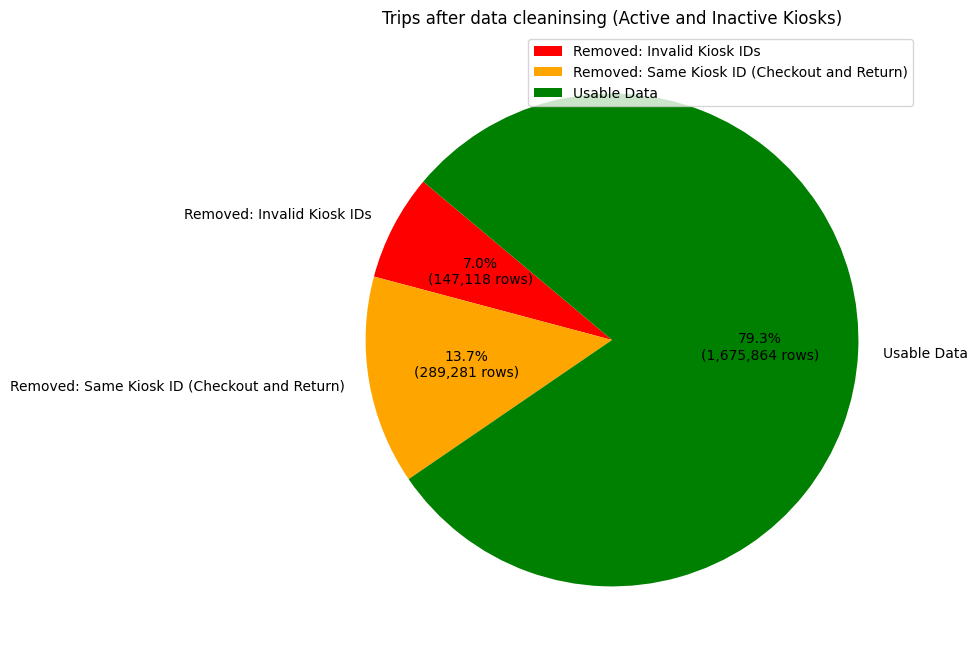

In [6]:
# Printing the number of rows in each DataFrame
print(f"Original DataFrame (data_df) rows: {len(data_df)}")
print(f"Rows after removing rows invalid Kiosk ID's: {len(filtered_df)}")
print(f"Rows after removing trips with identical checkout/return Kiosks: {len(filtered_df2)}")

# Number of rows in each DataFrame
original_rows = len(data_df)
rows_after_invalid_kiosk_ids = len(filtered_df)
rows_after_checkout_return_filter = len(filtered_df2)

# Calculating the number of rows removed in each step
rows_removed_invalid_kiosk_ids = original_rows - rows_after_invalid_kiosk_ids
rows_removed_checkout_return_filter = rows_after_invalid_kiosk_ids - rows_after_checkout_return_filter
usable_rows = rows_after_checkout_return_filter

# Labels for the pie chart
labels = [
    f'Removed: Invalid Kiosk IDs', 
    f'Removed: Same Kiosk ID (Checkout and Return)',
    f'Usable Data'
]

# Values for each slice of the pie chart
values = [
    rows_removed_invalid_kiosk_ids, 
    rows_removed_checkout_return_filter,
    usable_rows
]

# Colors for each slice of the pie chart
colors = ['red', 'orange', 'green']

# Create a pie chart
plt.figure(figsize=(10, 8))
plt.pie(values, labels=labels, colors=colors, autopct=lambda p: '{:.1f}%\n({:,.0f} rows)'.format(p, p * sum(values) / 100), startangle=140)
plt.legend()
plt.title('Trips after data cleaninsing (Active and Inactive Kiosks)')
plt.show()

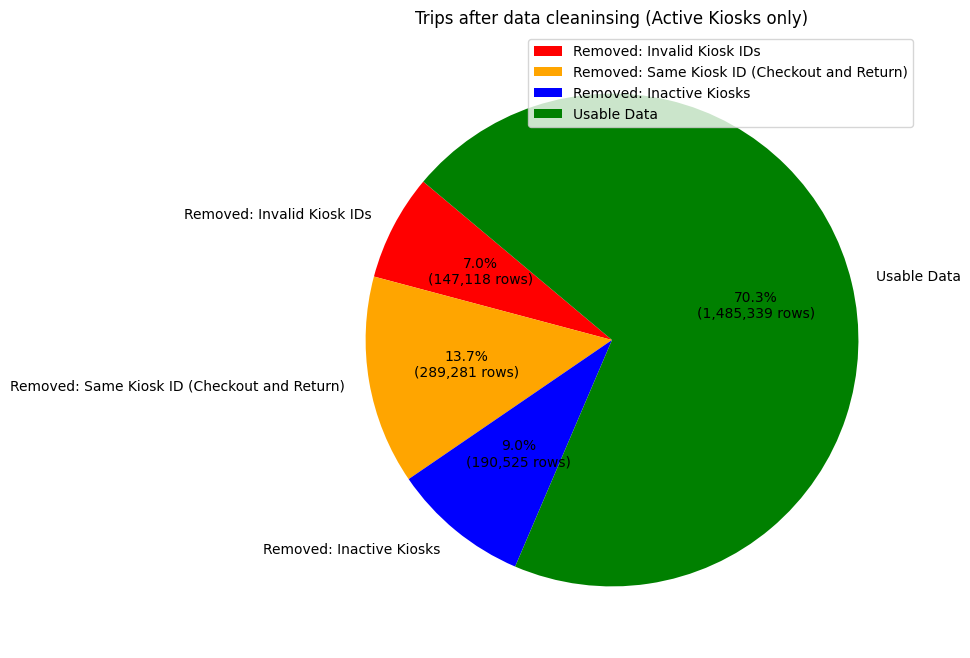

In [7]:
# Replace these counts with the actual lengths of your DataFrames
original_rows = len(data_df)
rows_after_invalid_kiosk_ids = len(filtered_df)
rows_after_checkout_return_filter = len(filtered_df2)
rows_on_active_kiosks = len(filtered_df3)

# Calculating the number of rows removed in each step
rows_removed_invalid_kiosk_ids = original_rows - rows_after_invalid_kiosk_ids
rows_removed_checkout_return_filter = rows_after_invalid_kiosk_ids - rows_after_checkout_return_filter
rows_removed_inactive_kiosks = rows_after_checkout_return_filter - rows_on_active_kiosks
usable_rows = rows_on_active_kiosks

# Labels for the pie chart
labels = [
    'Removed: Invalid Kiosk IDs', 
    'Removed: Same Kiosk ID (Checkout and Return)',
    'Removed: Inactive Kiosks',
    'Usable Data'
]

# Values for each slice of the pie chart
values = [
    rows_removed_invalid_kiosk_ids, 
    rows_removed_checkout_return_filter,
    rows_removed_inactive_kiosks,
    usable_rows
]

# Colors for each slice of the pie chart
colors = ['red', 'orange', 'blue', 'green']

# Create a pie chart
plt.figure(figsize=(10, 8))
plt.pie(values, labels=labels,colors = colors, autopct=lambda p: '{:.1f}%\n({:,.0f} rows)'.format(p, p * sum(values) / 100), startangle=140)
plt.title('Trips after data cleaninsing (Active Kiosks only)')
plt.legend()
plt.show()

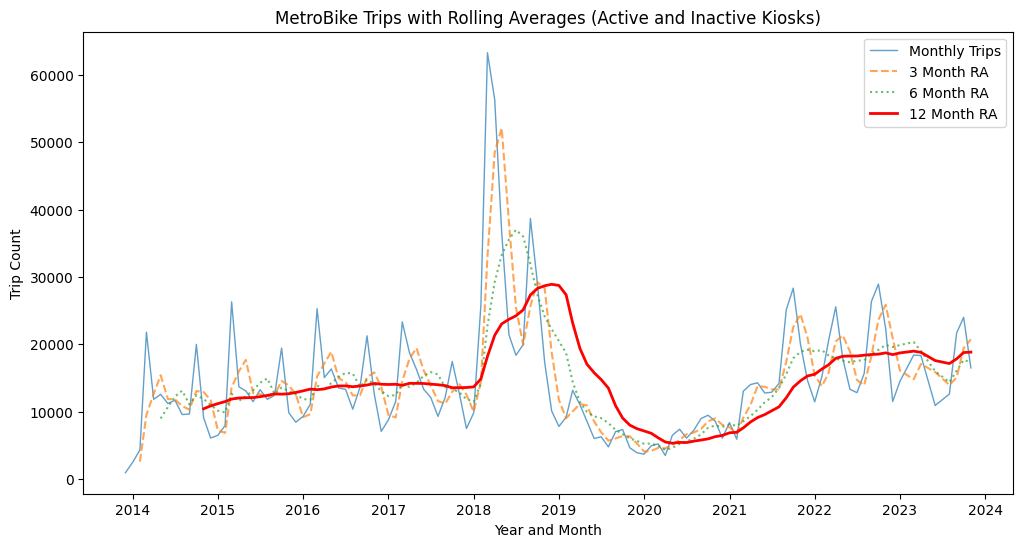

In [8]:
# Plotting the graph
plt.figure(figsize=(12, 6))
plt.plot(year_month_trip_df_all['Year_Month'], year_month_trip_df_all['Trip Count'], label='Monthly Trips', linewidth=1, alpha=0.7)
plt.plot(year_month_trip_df_all['Year_Month'], year_month_trip_df_all['3 Month MA'], label='3 Month RA', linestyle='--', alpha=0.7)
plt.plot(year_month_trip_df_all['Year_Month'], year_month_trip_df_all['6 Month MA'], label='6 Month RA', linestyle=':', alpha=0.7)
plt.plot(year_month_trip_df_all['Year_Month'], year_month_trip_df_all['12 Month MA'], label='12 Month RA', linestyle='-', linewidth=2, color='red')
plt.xlabel('Year and Month')
plt.ylabel('Trip Count')
plt.title('MetroBike Trips with Rolling Averages (Active and Inactive Kiosks)')
plt.legend()
plt.show()

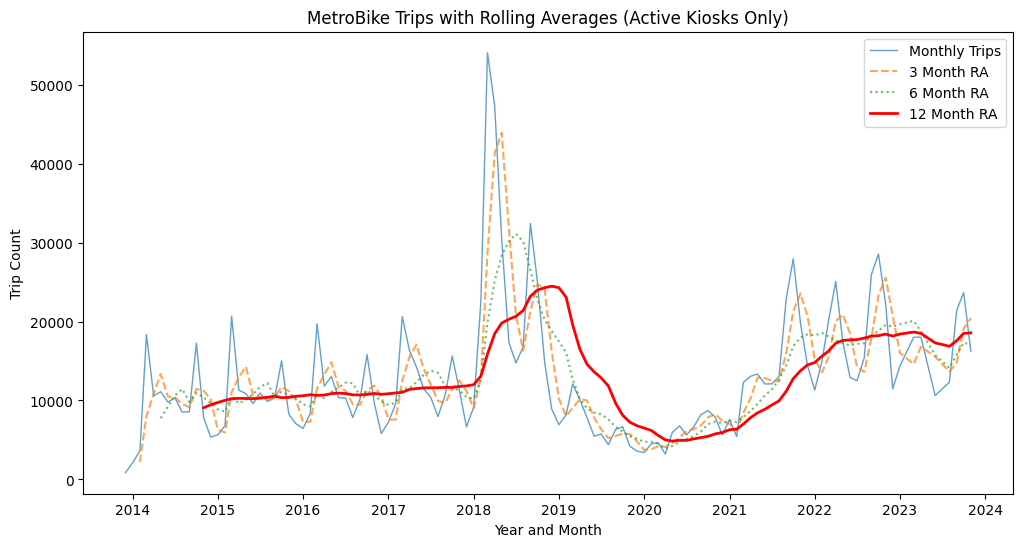

In [9]:
# Plotting the graph
plt.figure(figsize=(12, 6))
plt.plot(year_month_trip_df_active_only['Year_Month'], year_month_trip_df_active_only['Trip Count'], label='Monthly Trips', linewidth=1, alpha=0.7)
plt.plot(year_month_trip_df_active_only['Year_Month'], year_month_trip_df_active_only['3 Month MA'], label='3 Month RA', linestyle='--', alpha=0.7)
plt.plot(year_month_trip_df_active_only['Year_Month'], year_month_trip_df_active_only['6 Month MA'], label='6 Month RA', linestyle=':', alpha=0.7)
plt.plot(year_month_trip_df_active_only['Year_Month'], year_month_trip_df_active_only['12 Month MA'], label='12 Month RA', linestyle='-', linewidth=2, color='red')
plt.xlabel('Year and Month')
plt.ylabel('Trip Count')
plt.title('MetroBike Trips with Rolling Averages (Active Kiosks Only)')
plt.legend()
plt.show()

In [11]:
# display(kiosk_df)

# Saving kiosk_names_df to a CSV file
kiosk_df.to_csv('../../data/processed/Kiosk_with_LatLong.csv', index=False)
filtered_df3.to_json('../../data/processed/cleaned_metrobike_trips.json', orient='records')
kiosk_df.to_json('../../dist/data/processed/kiosk_coords.json', orient='records')